# E-Commerce Data Analysis: Exploratory Data Analysis (EDA)

**Author:** Saraswathi R  
**Last Updated:** 22-07-2025  
**Description:** Comprehensive EDA of e-commerce transaction data, including data cleaning, visualization, and initial insights.

## Table of Contents
1. [Setup and Data Loading](#1-Setup-and-Data-Loading)
2. [Initial Data Exploration](#2-Initial-Data-Exploration)
3. [Data Cleaning](#3-Data-Cleaning)
4. [Exploratory Analysis](#4-Exploratory-Analysis)
   - 4.1 [Time-Based Analysis](#41-Time-Based-Analysis)
   - 4.2 [Product Analysis](#42-Product-Analysis)
   - 4.3 [Customer Analysis](#43-Customer-Analysis)
   - 4.4 [Geographical Analysis](#44-Geographical-Analysis)
5. [Summary and Conclusions](#5-Summary-and-Conclusions)
6. [Next Steps](#6-Next-Steps)

## Setup and Data Loading

### Data Source and Preprocessing

#### Data Source
- **Primary Source**: Kaggle "ecommerce-data" dataset
- **Format**: Initially CSV, processed into Parquet format
- **ETL Pipeline**: Processed through Airflow DAG ([ecomm_invoice_etl_dag.py](cci:7://file:///e:/Smartcart_Retail_Analytics/src/dags/ecomm_invoice_etl_dag.py:0:0-0:0))

#### Data Cleaning (Performed in ETL)
1. **Missing Values**:
   - Empty `Description` → Filled with 'No Description'
   - Missing `CustomerID` → Set to 0

2. **Data Type Standardization**:
   - `InvoiceDate`: Converted to datetime
   - `StockCode`: Converted to string and standardized to uppercase
   - `CustomerID`: Converted to integer (missing values → 0)
   - `Description`: Ensured string type and standardized per `StockCode`

3. **Derived Column**:
   - `total_spend`: Calculated as `Quantity * UnitPrice`

4. **Data Quality Notes**:
   - Special `StockCode` values:
     - 'M' may indicate manual adjustments
     - Invoice numbers starting with 'C' indicate credit notes/returns
   - Descriptions have been standardized to the most frequent version per `StockCode`

#### Why Use the Parquet File?
1. **Efficiency**: 
   - Smaller file size than CSV
   - Faster read/write operations
   - Preserves data types (no need to re-parse dates/numbers)

2. **Consistency**:
   - Ensures everyone uses the same cleaned version
   - Removes need to reimplement cleaning logic

3. **Reproducibility**:
   - Contains all cleaning steps in one place
   - Version controlled through the ETL pipeline

In [3]:
import numpy as np
import pandas as pd
# import requests
# import io

In [4]:
# use encoding = 'latin1' because the data has a ( a currency sign lie $ ) that make it hard to be read without encoding.
# reading the uncleaned raw data.csv file
# df= pd.read_csv(r"E:\Smartcart_Retail_Analytics\data\uncleaned_data.csv", encoding= 'latin1')

In [ ]:
# Standard library imports
import os
from datetime import datetime


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

# Visualization settings
%matplotlib inline
sns.set_theme()
sns.set_palette('viridis')
pd.set_option('display.max_columns', None) # to show all the columns
pd.set_option('display.float_format', lambda x: '%.2f' % x) # setting all floating point numbers to 2 decimal places

# Set random seed for reproducibility
np.random.seed(42)

def load_data(filepath):
    """
    Load data from the specified file path.
    
    Args:
        filepath (str): Path to the data file
        
    Returns:
        pd.DataFrame: Loaded DataFrame
    """
    try:
        if filepath.endswith('.parquet'):  # parquet is a binary file format
            return pd.read_parquet(filepath)
        elif filepath.endswith('.csv'):  # csv is a text file format
            return pd.read_csv(filepath, encoding='latin1')
        else:
            raise ValueError("Unsupported file format. Please use .csv or .parquet")
    except Exception as e: # stores the error in variable e
        print(f"Error loading data: {e}")
        return None

# Load the data
print("Loading data...")
data_path = "E:\Smartcart_Retail_Analytics\data\ecomm_invoice_transaction.parquet"
df = load_data(data_path)

# Display basic information
print("\n=== Data Loaded Successfully ===")
print(f"Shape: {df.shape}")
display(df.head())

Loading data...

=== Data Loaded Successfully ===
Shape: (541909, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


## Initial Data Exploration

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

In [10]:
def initial_exploration(df):
    """
    Perform initial exploration of the dataset.
    
    Args:
        df (pd.DataFrame): Input DataFrame
    """
    print("=== Dataset Overview ===")
    print(f"Number of rows: {df.shape[0]}")
    print(f"Number of columns: {df.shape[1]}")
    
    print("\n=== Column Data Types ===")
    print(df.dtypes)

    print("\n=== First 5 Rows ===")
    display(df.head())


    # Identify numerical and categorical columns
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    datetime_cols = df.select_dtypes(include=['datetime64']).columns
    
    print("\n=== Numerical Columns Statistics ===")
    if not numeric_cols.empty:
        display(df[numeric_cols].describe().T)
    else:
        print("No numerical columns found.")
    
    print("\n=== Categorical Columns Statistics ===")
    if not categorical_cols.empty:
        display(df[categorical_cols].describe(include='O').T)
    else:
        print("No categorical columns found.")
        
    print("\n=== Datetime Columns Statistics ===")
    if not datetime_cols.empty:
        for col in datetime_cols:
            print(f"\nColumn: {col}")
            print(f"Min date: {df[col].min()}")
            print(f"Max date: {df[col].max()}")
            print(f"Unique dates: {df[col].nunique()}")
    else:
        print("No datetime columns found.")
    
    
    print("\n=== Missing Values ===")
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Values': missing,
        'Percentage (%)': missing_percent
    })
    display(missing_df[missing_df['Missing Values'] > 0])
    

    print("\n=== Duplicate Rows ===")
    print(f"Number of duplicate rows: {df.duplicated().sum()}")

    print("\n=== Unique Values per Column ===")
    for col in df.columns:
        print(f"{col}: {df[col].nunique():,} unique values")

# Run the exploration
print("Performing initial data exploration...")
initial_exploration(df)

Performing initial data exploration...
=== Dataset Overview ===
Number of rows: 541909
Number of columns: 9

=== Column Data Types ===
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country                object
total_spend           float64
dtype: object

=== First 5 Rows ===


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34



=== Numerical Columns Statistics ===


,count,mean,std,min,25%,50%,75%,max
Quantity,541909.00,9.55,218.08,-80995.00,1.00,3.00,10.00,80995.00
UnitPrice,541909.00,4.61,96.76,-11062.06,1.25,2.08,4.13,38970.00
CustomerID,541909.00,11476.97,6777.91,0.00,12352.00,14382.00,16255.00,18287.00
total_spend,541909.00,17.99,378.81,-168469.60,3.40,9.75,17.40,168469.60



=== Categorical Columns Statistics ===


,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,3958,85123A,2380
Description,541909,3800,WHITE HANGING HEART T-LIGHT HOLDER,2380
Country,541909,38,United Kingdom,495478



=== Datetime Columns Statistics ===

Column: InvoiceDate
Min date: 2010-12-01 08:26:00
Max date: 2011-12-09 12:50:00
Unique dates: 23260

=== Missing Values ===


,Missing Values,Percentage (%)



=== Duplicate Rows ===
Number of duplicate rows: 5270

=== Unique Values per Column ===
InvoiceNo: 25,900 unique values
StockCode: 3,958 unique values
Description: 3,800 unique values
Quantity: 722 unique values
InvoiceDate: 23,260 unique values
UnitPrice: 1,630 unique values
CustomerID: 4,373 unique values
Country: 38 unique values
total_spend: 6,204 unique values


## Data Cleaning

In [12]:
def clean_data(df):
    """
    Clean the e-commerce transaction data.
    
    Args:
        df (pd.DataFrame): Raw input data
        
    Returns:
        pd.DataFrame: Cleaned data
    """
    df_clean = df.copy()

    # Assumption: InvoiceDate should be in datetime format
    # If not, conversion will be attempted

    # Check current type of the InvoiceDate column
    # print("Current type:", df_clean['InvoiceDate'].dtype)
    
    # 1. Convert InvoiceDate to datetime
    # df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
    
    # 2. Create time-based features
    df_clean['Year'] = df_clean['InvoiceDate'].dt.year
    df_clean['Month'] = df_clean['InvoiceDate'].dt.month
    df_clean['Day'] = df_clean['InvoiceDate'].dt.day
    df_clean['DayOfWeek'] = df_clean['InvoiceDate'].dt.dayofweek
    df_clean['Hour'] = df_clean['InvoiceDate'].dt.hour
    df_clean['MonthYear'] = df_clean['InvoiceDate'].dt.to_period('M')
    
    # 3. Create total_spend if it doesn't exist
    if 'total_spend' not in df_clean.columns:
        df_clean['total_spend'] = df_clean['Quantity'] * df_clean['UnitPrice']
    
    # 4. Handle returns (negative quantities)
    df_clean['IsReturn'] = df_clean['Quantity'] < 0
    
    print("Data cleaning completed.")
    return df_clean

# Clean the data
print("Cleaning data...")
df_clean = clean_data(df)

# Display cleaned data info
print("\n=== Cleaned Data Info ===")
display(df_clean.head())

Cleaning data...
Data cleaning completed.

=== Cleaned Data Info ===


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend,Year,Month,Day,DayOfWeek,Hour,MonthYear,IsReturn
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010,12,1,2,8,2010-12,False
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1,2,8,2010-12,False
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010,12,1,2,8,2010-12,False
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1,2,8,2010-12,False
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1,2,8,2010-12,False


## Exploratory Analysis


### Time-Based Analysis

Analyzing sales trends...


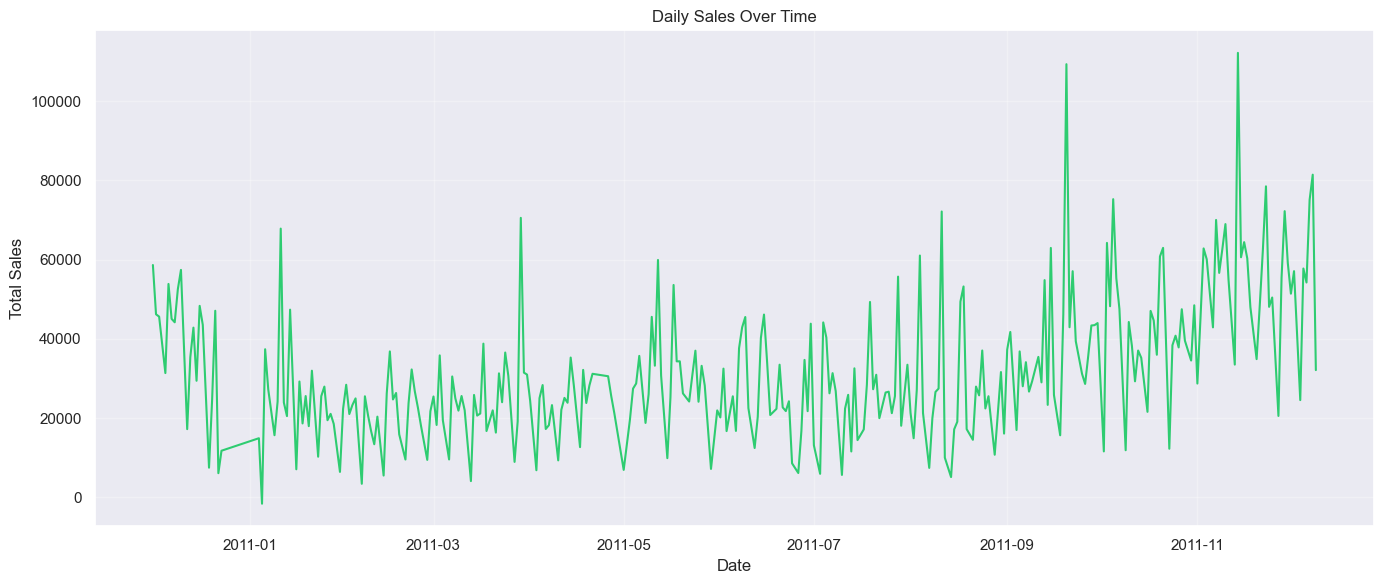

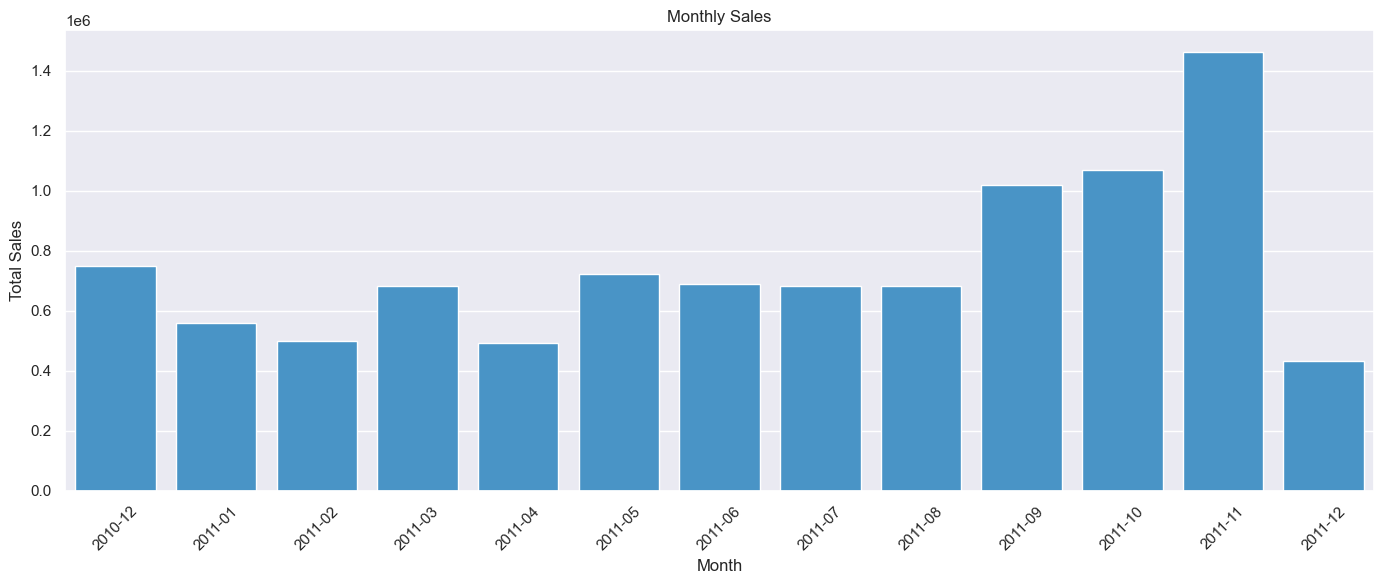

In [14]:
def plot_sales_trends(df):
    """
    Plot sales trends over time.
    """
    # Group by date and calculate daily sales
    daily_sales = df.groupby(df['InvoiceDate'].dt.date)['total_spend'].sum()
    
    # Create figure
    plt.figure(figsize=(14, 6))
    daily_sales.plot(title='Daily Sales Over Time', color='#2ecc71')
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Monthly sales
    monthly_sales = df.groupby('MonthYear')['total_spend'].sum().reset_index()
    monthly_sales['MonthYear'] = monthly_sales['MonthYear'].astype(str)
    
    plt.figure(figsize=(14, 6))
    sns.barplot(x='MonthYear', y='total_spend', data=monthly_sales, color='#3498db')
    plt.title('Monthly Sales')
    plt.xlabel('Month')
    plt.ylabel('Total Sales')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot sales trends
print("Analyzing sales trends...")
plot_sales_trends(df_clean)

### Product analysis

In [ ]:
# Summary of the following action:
# 1. Creating column Is_Return to identify return transactions
# 2. Creating column Net_Quantity to convert returns to 0 for sales analysis
# 3. Overall metrics
# 4. Sales Analysis (Positive Quantities)
        # Top selling products by quantity
        # Top products by revenue
# 5. Returns Analysis (Negative Quantities)
        # Top returns
        # Return rate by product
        # products with significant sales (more than 100 units)
        # products with highest return rates        
# 6. Price Distribution Analysis
# 7. Price vs. Return Rate Analysis


Analyzing product data...
=== Overall Product Metrics ===
Total unique products: 3,958
Total transactions: 541,909
Return transactions: 10,624 (2.0%)

=== Sales Analysis (Positive Quantities) ===
Total items sold: 5,660,981


C:\Users\shanu\AppData\Local\Temp\ipykernel_32136\2230083824.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_products_qty.values, y=top_products_qty.index, palette='viridis')


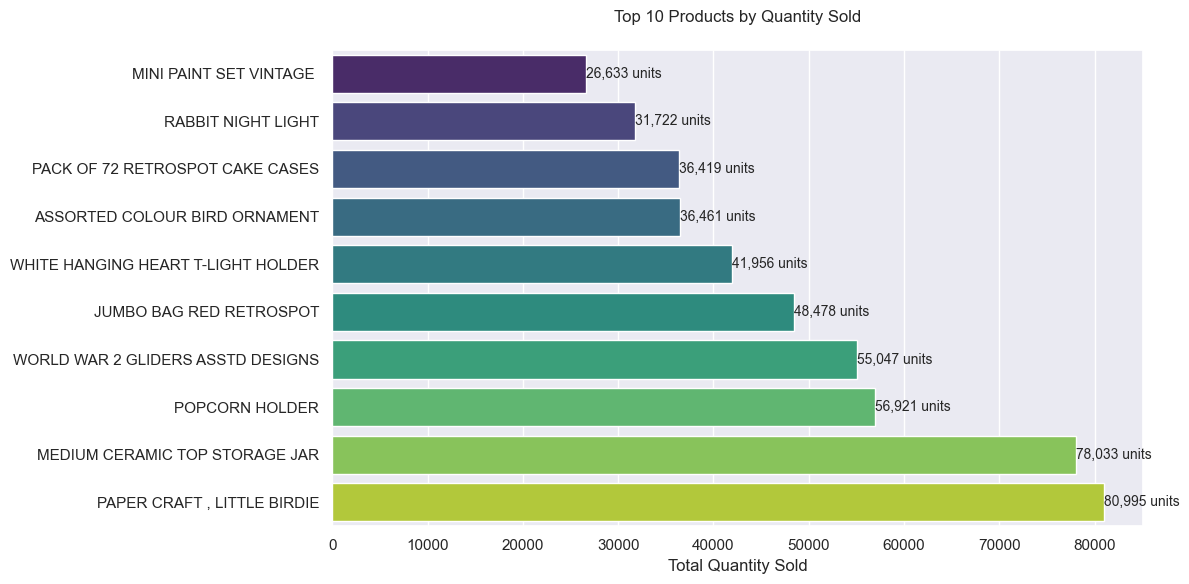

C:\Users\shanu\AppData\Local\Temp\ipykernel_32136\2230083824.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_products_rev.values,


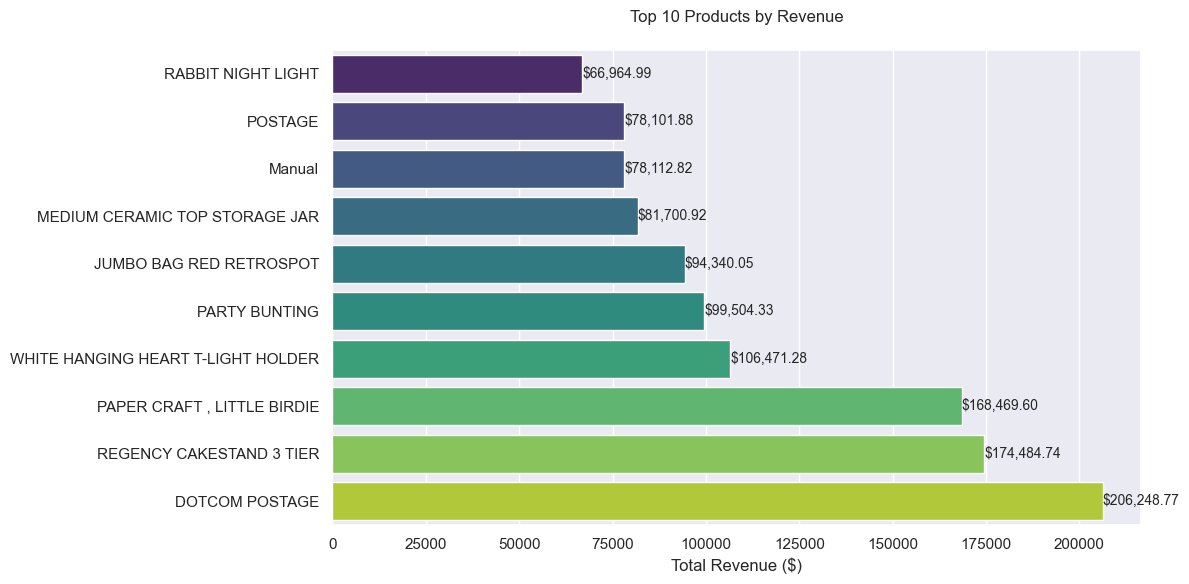


=== Returns Analysis (Negative Quantities) ===


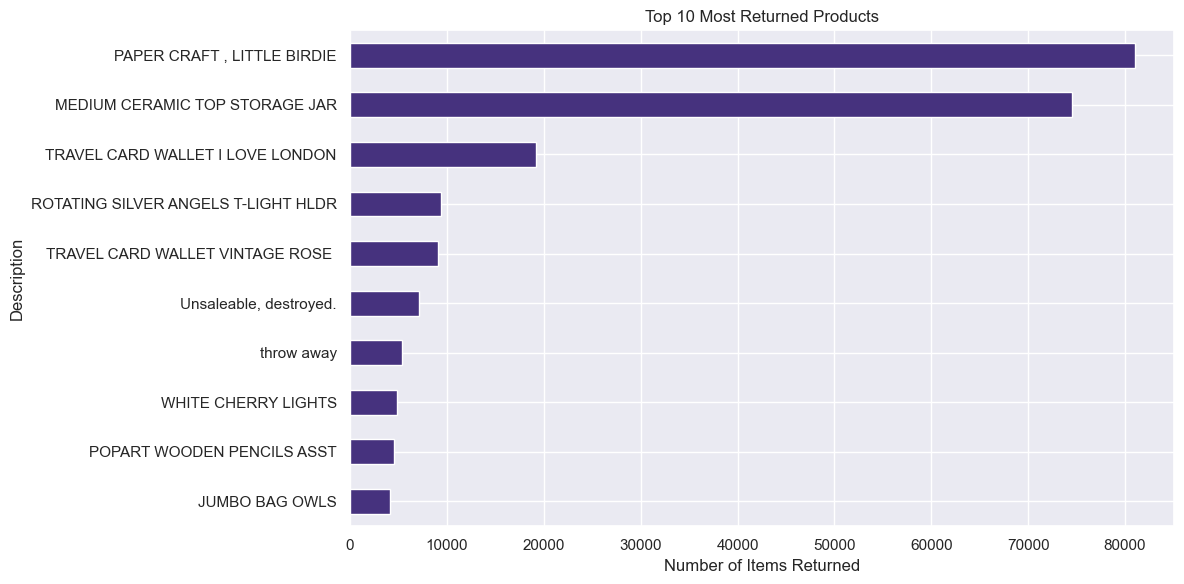

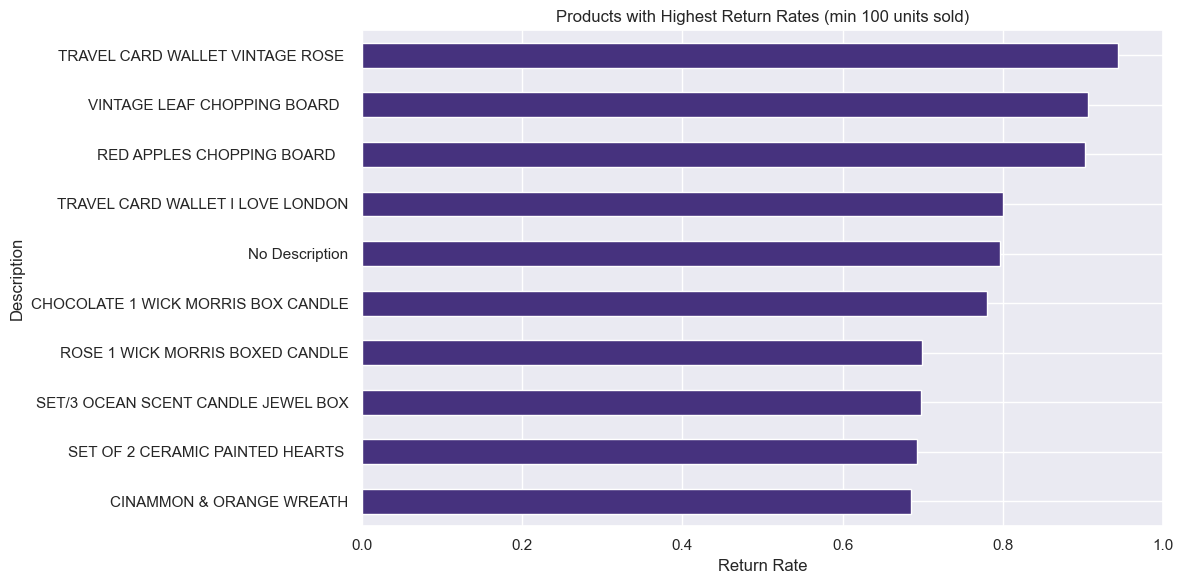


=== Price Distribution ===


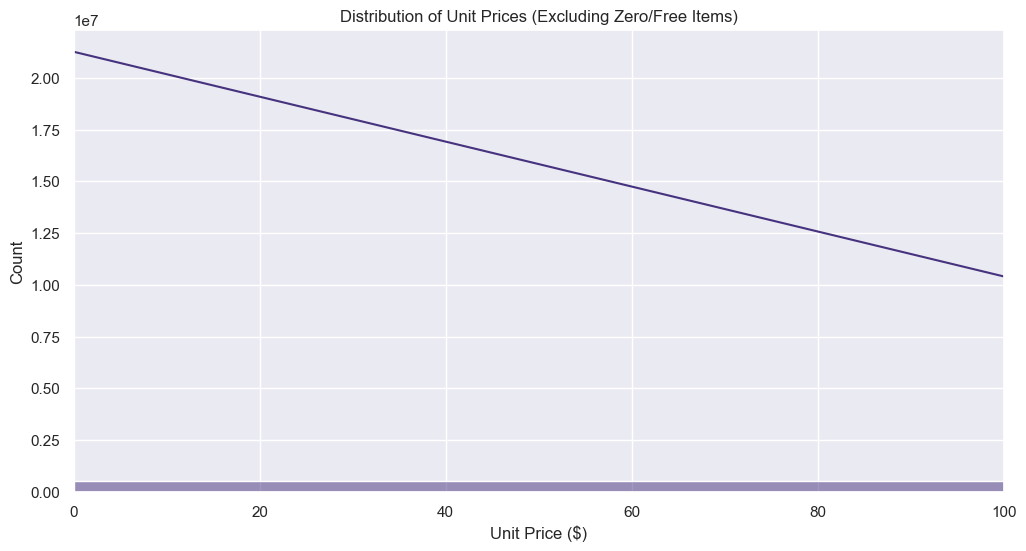


=== Price vs. Return Rate ===


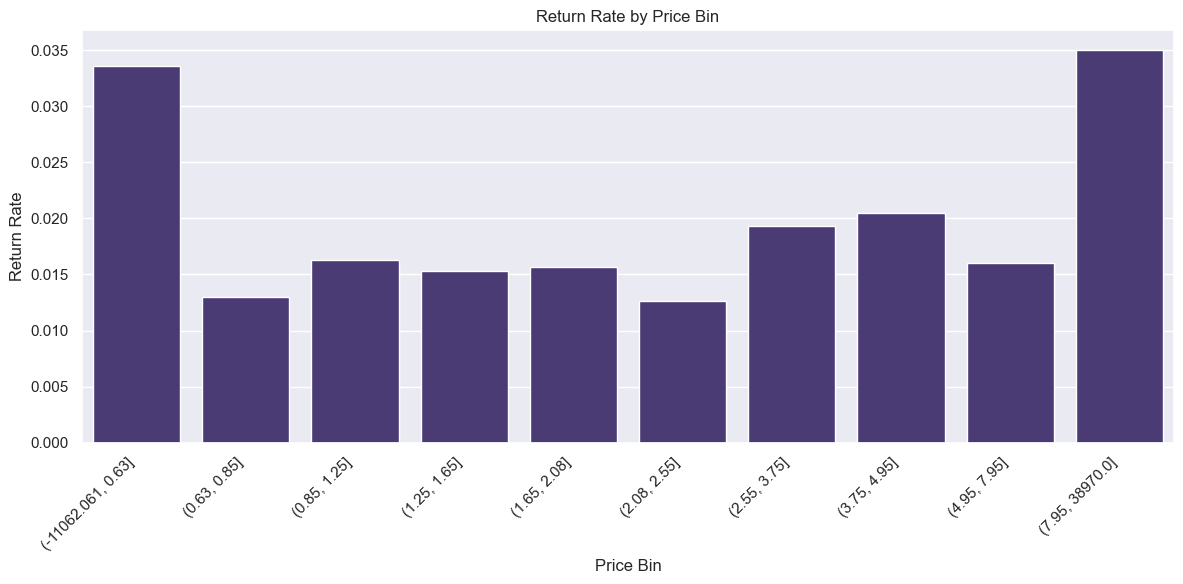

In [16]:
## Product Analysis

def analyze_products(df):
    """
    Analyze product performance including sales and returns.
    Separates analysis of positive quantities (sales) and negative quantities (returns).
    """
    # Create a copy to avoid SettingWithCopyWarning
    df_products = df.copy()
    
    # What Negative Quantities Mean:
        # Returns: When a customer returns an item
        # Cancellations: When an order is canceled after being recorded
        # Adjustments: Manual corrections to inventory

    # Create flags and net quantity for analysis
    df_products['Is_Return'] = df_products['Quantity'] < 0
    df_products['Net_Quantity'] = df_products['Quantity'].clip(lower=0)  
    # Convert returns to 0 for sales analysis to ignore the returns 
    # For each value:
        # If the value is negative, it changes it to 0
        # If the value is positive or zero, it keeps the original value
     
    # 1. Overall Metrics
    print("=== Overall Product Metrics ===")
    total_products = df_products['StockCode'].nunique()
    total_transactions = len(df_products)
    return_transactions = df_products['Is_Return'].sum()
    
    print(f"Total unique products: {total_products:,}")
    print(f"Total transactions: {total_transactions:,}")
    print(f"Return transactions: {return_transactions:,} ({return_transactions/total_transactions:.1%})")
    
    # 2. Sales Analysis (Positive Quantities)
    print("\n=== Sales Analysis (Positive Quantities) ===")
    # Filter out returns and keep only necessary columns
    sales = df_products[~df_products['Is_Return']].copy() 
    # The ~ (tilde) is a logical NOT operator. It flips all the True/False values.
    # df_products['Is_Return'] means return transactions
    # ~df_products['Is_Return'] means not return transactions
    # This gives only the actual sales after eliminating the returns
    sales = sales[['Description', 'Net_Quantity', 'UnitPrice', 'total_spend']]
    
    # Now we can safely use Net_Quantity which is the same as Quantity but more explicit
    print(f"Total items sold: {sales['Net_Quantity'].sum():,}")

    # Top selling products by quantity
    top_products_qty = sales.groupby('Description')['Net_Quantity'].sum().nlargest(10).sort_values()
    
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=top_products_qty.values, y=top_products_qty.index, palette='viridis')
    # Add value labels
    for i, v in enumerate(top_products_qty):
        ax.text(v + 5, i, f'{v:,.0f} units', va='center', ha='left', fontsize=10)
    plt.title('Top 10 Products by Quantity Sold', pad=20)
    plt.xlabel('Total Quantity Sold')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()
    
    # Top products by revenue
    sales['Revenue'] = sales['Net_Quantity'] * sales['UnitPrice']
    top_products_rev = sales.groupby('Description')['Revenue'].sum().nlargest(10).sort_values()
    
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=top_products_rev.values, 
                y=top_products_rev.index, 
                palette='viridis')

    # Add value labels
    for i, v in enumerate(top_products_rev):
        ax.text(v + 10, i, f'${v:,.2f}', 
            va='center', ha='left',
            fontsize=10)
    plt.title('Top 10 Products by Revenue', pad=20)
    plt.xlabel('Total Revenue ($)')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()


    
    # 3. Returns Analysis (Negative Quantities)
    print("\n=== Returns Analysis (Negative Quantities) ===")
    returns = df_products[df_products['Is_Return']].copy()
    
    if not returns.empty:
        # Most returned products
        top_returns = returns.groupby('Description')['Quantity'].sum().nsmallest(10)  # nsmallest because returns are negative
        
        plt.figure(figsize=(12, 6))
        (-top_returns).sort_values().plot(kind='barh')  # Convert to positive for display
        plt.title('Top 10 Most Returned Products')
        plt.xlabel('Number of Items Returned')
        plt.tight_layout()
        plt.show()
        
        # Return rate by product (for products with at least 100 units sold)
        product_stats = df_products.groupby('Description').agg({
            'Quantity': [('Total_Sold', lambda x: x[x>0].sum()),
                        ('Total_Returned', lambda x: -x[x<0].sum())]  # Convert returns to positive
        })
        # When we used .agg() with multiple aggregation functions, pandas created a MultiIndex for the columns.
        # Level 0: 'Quantity'         'Quantity'
        # Level 1: 'Total_Sold'       'Total_Returned'
        # columns.droplevel(0): Removes the first level of the column index
        # Now columns are just: 'Total_Sold' and 'Total_Returned'
        product_stats.columns = product_stats.columns.droplevel(0)
        product_stats = product_stats.fillna(0)

        # Calculate return rate: returns / (sales + returns)
        product_stats['Return_Rate'] = (product_stats['Total_Returned'] / 
                                      (product_stats['Total_Sold'] + product_stats['Total_Returned']))
        
        # Filter for products with significant sales
        # Focus on products with significant sales (more than 100 units)
        # Get the 10 products with highest return rates
        significant_products = product_stats[product_stats['Total_Sold'] > 100]
        high_return_products = significant_products.nlargest(10, 'Return_Rate')
        
        plt.figure(figsize=(12, 6))
        high_return_products['Return_Rate'].sort_values().plot(kind='barh')
        plt.title('Products with Highest Return Rates (min 100 units sold)')
        plt.xlabel('Return Rate')
        plt.xlim(0, 1)
        plt.tight_layout()
        plt.show()
    else:
        print("No return transactions found in the dataset.")
    
    # 4. Price Distribution Analysis
    print("\n=== Price Distribution ===")
    plt.figure(figsize=(12, 6))
    # Only includes items with positive prices
    # This excludes free items (price = 0) and any potential negative prices
    sns.histplot(df_products[df_products['UnitPrice'] > 0]['UnitPrice'], bins=50, kde=True)
    plt.title('Distribution of Unit Prices (Excluding Zero/Free Items)')
    plt.xlim(0, 100)  # Limit x-axis for better visualization, Focuses on the main price range (excludes very high outliers)
    plt.xlabel('Unit Price ($)')
    plt.show()
    
    # 5. Price vs. Return Rate Analysis
    if not returns.empty:
        print("\n=== Price vs. Return Rate ===")
        # Bin products by price
        # pd.qcut() is a function that splits the data into quantiles (equal parts)
        # q=10 means it will split the data into 10 equal parts
        # duplicates='drop' means it will drop any duplicates
        df_products['Price_Bin'] = pd.qcut(df_products['UnitPrice'], 
                                         q=10, 
                                         duplicates='drop')
        
        # In each price group/ bin, 'Is_Return" boolean column is counted
        # 'count' counts the number of transactions in each bin (both returns(True)and purchases(False))
            # ==> which gives the total trnsactions per bin
        # 'mean' calculates the average return rate in each bin
            # ==> mean= sum of returns(sum of all values--> only true values added up) / total number ofvalues
        price_return = df_products.groupby('Price_Bin').agg({
            'Is_Return': ['count', 'mean']
        })
        price_return.columns = ['Total_Transactions', 'Return_Rate']
        
        plt.figure(figsize=(12, 6))
        # Takes the index of price_return (which are the price bins like "$0-$10")
        # Converts them to strings (just to be safe), These will be the labels on the x-axis

        # price_return is a DataFrame with Price_Bin as index
        # reset_index() makes Price_Bin a regular column
        # This is needed-->  because seaborn needs column names, not index names

        sns.barplot(x=price_return.index.astype(str), y='Return_Rate', data=price_return.reset_index())
        plt.title('Return Rate by Price Bin')
        plt.xlabel('Price Bin')
        plt.ylabel('Return Rate')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

# Run the analysis
print("Analyzing product data...")
analyze_products(df)

### customer analysis

Analyzing customer behavior...


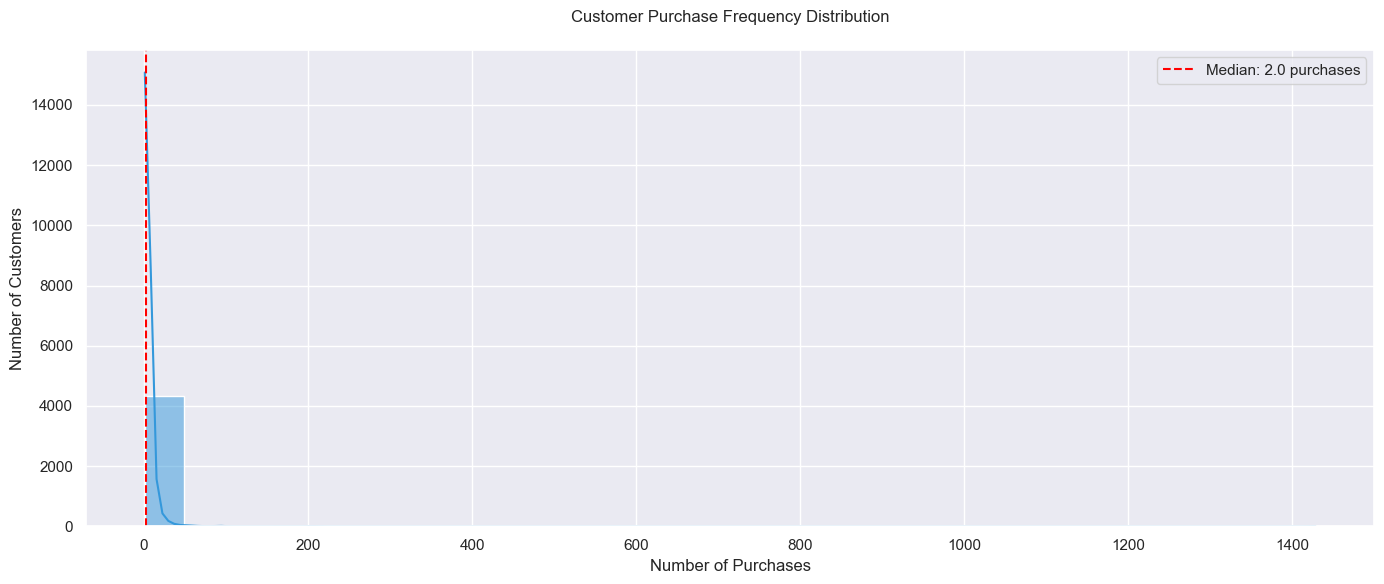

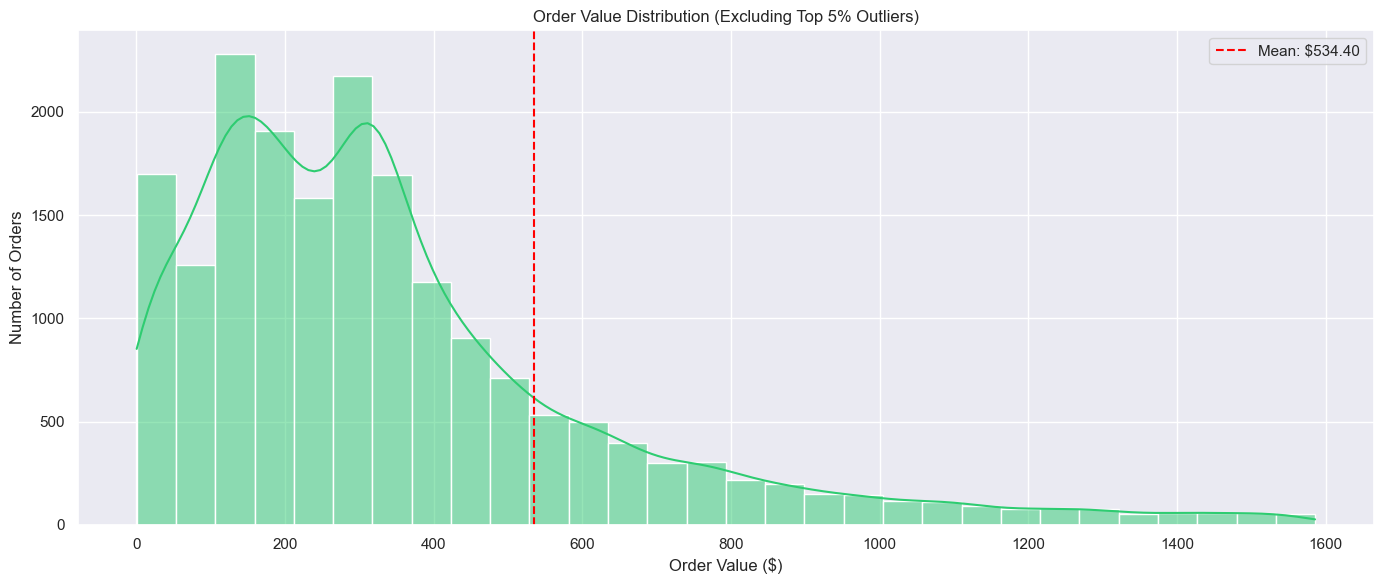


=== Customer Analysis Summary ===
Total Unique Customers: 4,339
Total Orders Placed: 19,960
Repeat Customers: 2,846 (65.6%)
Average Order Value: $534.40
Median Order Value: $303.84


In [18]:
def analyze_customers(df):
    """
    Customer behavior analysis with more metrics and visualizations.
    """
    # 1. Basic customer metrics
    total_customers = df['CustomerID'].nunique()
    total_orders = df['InvoiceNo'].nunique()
    
    # 2. Purchase frequency distribution
    customer_purchases = df.groupby('CustomerID')['InvoiceNo'].nunique()
    repeat_customers = (customer_purchases > 1).sum()
    
    # 3. Plot histogram
    plt.figure(figsize=(14, 6))
    ax = sns.histplot(customer_purchases, 
                     bins=30, 
                     kde=True,
                     color='#3498db')
    
    # Add median line
    median_purchases = customer_purchases.median()
    plt.axvline(median_purchases, color='red', linestyle='--', 
               label=f'Median: {median_purchases:.1f} purchases')
    
    # Add value labels
    #for rect in ax.patches:
    #    if rect.get_height() > 0:
    #        ax.text(rect.get_x() + rect.get_width()/2, 
    #               rect.get_height() + 5, 
    #               f'{int(rect.get_height())}',
    #               ha='center', va='bottom')
    
    plt.title('Customer Purchase Frequency Distribution', pad=20)
    plt.xlabel('Number of Purchases')
    plt.ylabel('Number of Customers')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 4. Calculate and display key metrics
    order_values = df.groupby('InvoiceNo')['total_spend'].sum()
    avg_order_value = order_values.mean()
    median_order_value = order_values.median()
    
    # 5. Plot order value distribution
    plt.figure(figsize=(14, 6))
    sns.histplot(order_values[order_values < order_values.quantile(0.95)],  # Remove top 5% outliers
                bins=30, 
                kde=True,
                color='#2ecc71')
    plt.title('Order Value Distribution (Excluding Top 5% Outliers)')
    plt.xlabel('Order Value ($)')
    plt.ylabel('Number of Orders')
    plt.axvline(avg_order_value, color='red', linestyle='--', 
               label=f'Mean: ${avg_order_value:,.2f}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 6. Print summary statistics
    print("\n=== Customer Analysis Summary ===")
    print(f"Total Unique Customers: {total_customers:,}")
    print(f"Total Orders Placed: {total_orders:,}")
    print(f"Repeat Customers: {repeat_customers:,} ({(repeat_customers/total_customers)*100:.1f}%)")
    print(f"Average Order Value: ${avg_order_value:,.2f}")
    print(f"Median Order Value: ${median_order_value:,.2f}")
    print("="*50)

# Run analysis on non-return transactions
print("Analyzing customer behavior...")
analyze_customers(df_clean[df_clean['total_spend'] > 0])

In [ ]:
def analyze_customers(df):
    """
    Analyze customer behavior.
    """
    # Customer distribution by purchase count
    customer_purchases = df.groupby('CustomerID')['InvoiceNo'].nunique().sort_values(ascending=False)
    
    plt.figure(figsize=(12, 6))
    customer_purchases.hist(bins=50, color='#3498db')
    plt.title('Distribution of Purchase Frequency per Customer')
    plt.xlabel('Number of Purchases')
    plt.ylabel('Number of Customers')
    plt.tight_layout()
    plt.show()
    
    # Average order value
    order_values = df.groupby('InvoiceNo')['total_spend'].sum()
    avg_order_value = order_values.mean()
    print(f"Average Order Value: ${avg_order_value:.2f}")

# Analyze customers
print("Analyzing customer behavior...")
analyze_customers(df_clean[df_clean['total_spend'] > 0])  # Exclude returns

### Summary and conclusions

## 5. Summary and Conclusions

### Key Findings:
1. **Data Quality**:
   - [Summary of data quality issues found]
   - [Handling of missing values and outliers]

2. **Sales Trends**:
   - [Key observations about sales patterns]
   - [Seasonal trends if any]

3. **Product Analysis**:
   - [Top performing products]
   - [Price distribution insights]

4. **Customer Behavior**:
   - [Purchase frequency distribution]
   - [Average order value]

### Recommendations:
1. [Actionable insights for business]
2. [Suggestions for further analysis]
3. [Potential areas for improvement]

## 6. Next Steps

1. **Model Development**:
   - Customer segmentation using RFM analysis
   - Market basket analysis
   - Demand forecasting
   - Churn prediction

2. **Further Analysis**:
   - Cohort analysis
   - Customer lifetime value prediction
   - Price elasticity analysis

3. **Dashboard Development**:
   - Create interactive dashboards for business users
   - Set up automated reporting

# Notebook for cleaning, EDA, and Model Development
---
*By Saraswathi R.*

In [ ]:
# 1. Data Loading and Initial Exploration
## 1.1 Import Libraries
## 1.2 Load Data
## 1.3 Initial Data Inspection

# 2. Data Cleaning
## 2.1 Handle Missing Values
## 2.2 Handle Negative Values (Returns/Refunds)
## 2.3 Handle Outliers
## 2.4 Standardize Data Types

# 3. Exploratory Data Analysis
## 3.1 Time Series Analysis
## 3.2 Customer Analysis
## 3.3 Product Analysis
## 3.4 Geographic Analysis

# 4. Feature Engineering
## 4.1 Create New Features
## 4.2 Prepare Data for Modeling

# 5. Save Processed Data

## Load Data

In [135]:
import numpy as np
import pandas as pd
# import requests
# import io

In [ ]:
# response = requests.get("https://github.com/Patcharanat/GrabSpark-Data-Analytics-for-Business-Use-Cases/blob/master/sample_a.csv")
# pd.read_csv(response.content)
# pd.read_csv(io.StringIO(response.content.decode('utf-8')))

# must use raw file (corrected approach)
# response = requests.get("https://raw.githubusercontent.com/Patcharanat/ecommerce-invoice/master/data/cleaned_data.csv")
# content = response.text
# print(content)

In [ ]:
# use encoding = 'latin1' because the data has a ( a currency sign lie $ ) that make it hard to be read without encoding.
# reading the uncleaned raw data.csv file
# df= pd.read_csv(r"E:\Smartcart_Retail_Analytics\data\uncleaned_data.csv", encoding= 'latin1')

In [ ]:
# df = pd.read_csv("./data/uncleaned_data.csv", encoding='cp1252')
# df = pd.read_csv("./data/uncleaned_data.csv")
# df = pd.read_csv("./data/data_url_uncleaned.csv", low_memory=False)
# df = pd.read_csv("./data/data_api_uncleaned.csv", encoding='cp1252')
# df = pd.read_csv("./data/data_postgres_cleaned.csv", encoding='cp1252')
# df = pd.read_csv("./data/data_postgres_cleaned.csv")
# df = pd.read_csv("./data/data_api_uncleaned.csv")
# df = pd.read_csv("https://raw.githubusercontent.com/Patcharanat/ecommerce-invoice/master/data/cleaned_data.csv")

# reading the cleaned data in parquet format that is stored 
df = pd.read_parquet("E:\Smartcart_Retail_Analytics\data\ecomm_invoice_transaction.parquet")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


## Domain Knowledge

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## Basic checks & Data cleaning

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  541909 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   541909 non-null  int64         
 7   Country      541909 non-null  object        
 8   total_spend  541909 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 37.2+ MB


In [15]:
df.describe()

,Quantity,UnitPrice,CustomerID,total_spend
count,541909.000000,541909.000000,541909.000000,541909.000000
mean,9.552250,4.611114,11476.974671,17.987795
std,218.081158,96.759853,6777.908326,378.810824
min,-80995.000000,-11062.060000,0.000000,-168469.600000
25%,1.000000,1.250000,12352.000000,3.400000
50%,3.000000,2.080000,14382.000000,9.750000
75%,10.000000,4.130000,16255.000000,17.400000
max,80995.000000,38970.000000,18287.000000,168469.600000


In [ ]:
# Data Quality issues
# 1. Negative values in Quantity and UnitPrice: Returns/ Refunds (normal), Possibel data entry errors
# 2. Extreme values: very large orders (80, 995)--> These could be legitimate or errors

In [ ]:
# for catgorical features
df.describe(include= 'O').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,3958,85123A,2380
Description,541909,3800,WHITE HANGING HEART T-LIGHT HOLDER,2380
Country,541909,38,United Kingdom,495478


In [25]:
df.nunique()

InvoiceNo      25900
StockCode       3958
Description     3800
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4373
Country           38
total_spend     6204
dtype: int64

In [7]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
total_spend    0
dtype: int64

In [ ]:
df.loc[df['Description'].isnull()].head()
# df.loc[df['Description'].isnull() & df['CustomerID'].isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend


In [19]:
df.loc[df['CustomerID'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend


In [ ]:
# checking unitprice for negative values
df.loc[df['UnitPrice'] < 0]

# only two rows

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,0,United Kingdom,-11062.06
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,0,United Kingdom,-11062.06


In [ ]:
df.loc[df['Quantity'] < 0]

# 10624 rows

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom,-27.50
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom,-4.65
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom,-19.80
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,-6.96
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,-6.96
...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom,-9.13
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498,United Kingdom,-224.69
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom,-54.75
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315,United Kingdom,-1.25


In [23]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'total_spend'],
      dtype='object')

In [12]:
df.loc[df['StockCode'] == 'm']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend


In [33]:
df.loc[df['InvoiceNo'] == 'C536379']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.5,14527,United Kingdom,-27.5


<Axes: >

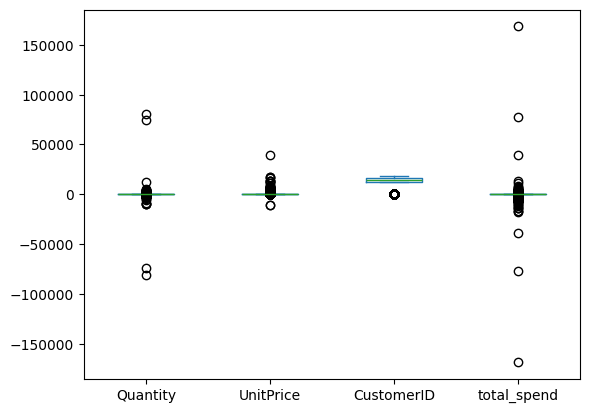

In [34]:
df.plot(kind='box')

### Fill NA

In [35]:
df_temp = df.copy()

In [36]:
df_temp['Description'] = df['Description'].fillna('No Description')

In [37]:
df_temp['CustomerID'] = df['CustomerID'].fillna(0)
df_temp['CustomerID'] = df_temp['CustomerID'].astype(float).astype(int)

In [38]:
df_temp['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [39]:
df_temp.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
total_spend    0
dtype: int64

In [ ]:
df_temp.head()

In [41]:
df_temp['InvoiceNo'] = df_temp['InvoiceNo'].astype(str)
df_temp['StockCode'] = df_temp['StockCode'].astype(str)
df_temp['Description'] = df_temp['Description'].astype(str)
# df_temp['Quantity'] = df_temp['Quantity']
# df_temp['InvoiceDate'] = df_temp['InvoiceDate']
# df_temp['UnitPrice'] = df_temp['UnitPrice'].astype('float64')
df_temp['Country'] = df_temp['Country'].astype(str)

In [55]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  541909 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   541909 non-null  int32         
 7   Country      541909 non-null  object        
 8   total_spend  541909 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(4)
memory usage: 35.1+ MB


In [60]:
df_temp.to_csv(r"E:\Smartcart_Retail_Analytics\data\cleaned_data.csv", index=False)


## EDA

In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# sns.set(style="dark")
plt.style.use("ggplot")

In [62]:
df_temp = pd.read_csv(r"E:\Smartcart_Retail_Analytics\data\cleaned_data.csv") # 

In [63]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  541909 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   541909 non-null  int64  
 7   Country      541909 non-null  object 
 8   total_spend  541909 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 37.2+ MB


In [ ]:
# total amount spent per row

df_temp["total_spend"] = df_temp["Quantity"] * df_temp["UnitPrice"]
df_temp.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [68]:
daily_sales = df_temp.groupby('InvoiceDate')['total_spend'].sum().sort_index()
x = daily_sales.index
y = daily_sales.values

In [69]:
x

Index(['2010-12-01 08:26:00', '2010-12-01 08:28:00', '2010-12-01 08:34:00',
       '2010-12-01 08:35:00', '2010-12-01 08:45:00', '2010-12-01 09:00:00',
       '2010-12-01 09:01:00', '2010-12-01 09:02:00', '2010-12-01 09:09:00',
       '2010-12-01 09:32:00',
       ...
       '2011-12-09 12:09:00', '2011-12-09 12:16:00', '2011-12-09 12:19:00',
       '2011-12-09 12:20:00', '2011-12-09 12:21:00', '2011-12-09 12:23:00',
       '2011-12-09 12:25:00', '2011-12-09 12:31:00', '2011-12-09 12:49:00',
       '2011-12-09 12:50:00'],
      dtype='object', name='InvoiceDate', length=23260)

In [70]:
y

array([139.12,  22.2 , 348.78, ..., 329.05, 339.2 , 249.45])

In [71]:
timeseries_data = pd.DataFrame({'invoice_date': x, 'total_spend': y})
timeseries_data.head()

,invoice_date,total_spend
0,2010-12-01 08:26:00,139.12
1,2010-12-01 08:28:00,22.20
2,2010-12-01 08:34:00,348.78
3,2010-12-01 08:35:00,17.85
4,2010-12-01 08:45:00,855.86


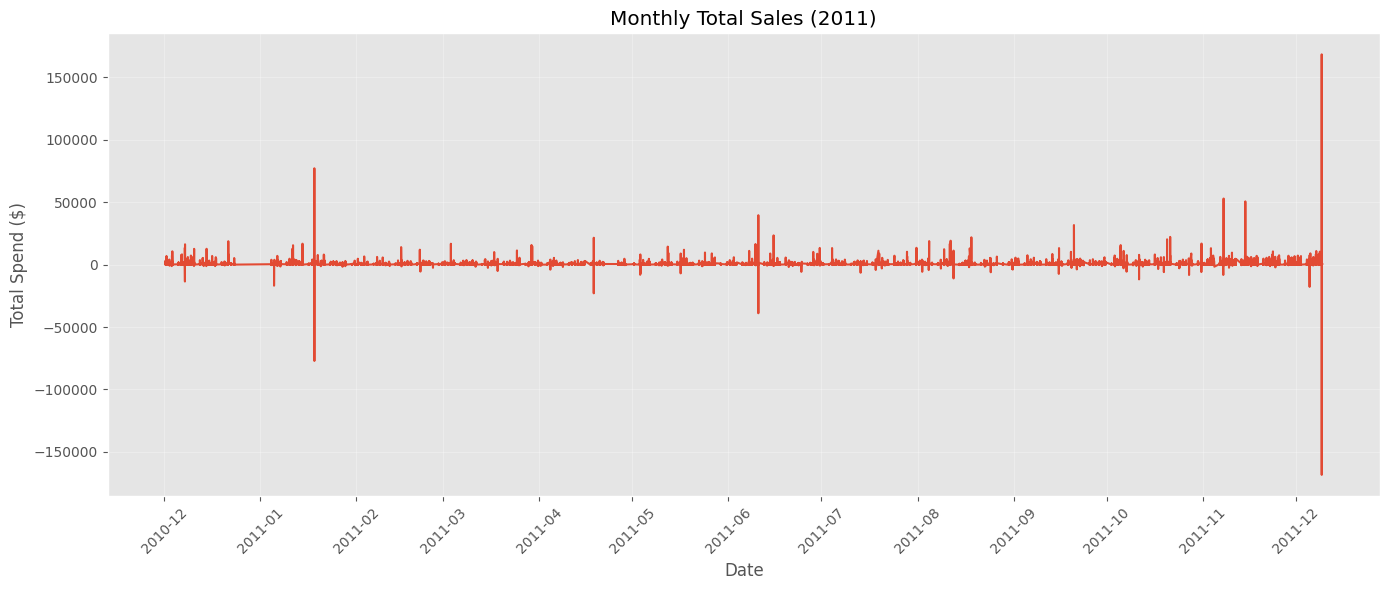

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Ensure datetime and set as index (most efficient)
timeseries_data['invoice_date'] = pd.to_datetime(timeseries_data['invoice_date'])
timeseries_data = timeseries_data.set_index('invoice_date')

# 2. Create the plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=timeseries_data, x=timeseries_data.index, y='total_spend')

# 3. Format the x-axis
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=1))

# Shows full date with time (e.g., "2023-01-15 00:00:00")
# plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M:%S'))

# # Shows abbreviated month and year (e.g., "Jan 2023")
# .DateFormatter('%b %Y'))

# Shows quarter and year (e.g., "Q1-2023")
# .DateFormatter('Q%q-%Y'))

# 4. Add labels and style
plt.title('Monthly Total Sales (2011)')
plt.xlabel('Date')
plt.ylabel('Total Spend ($)')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

### EXTRAS (for later)
Key Insights from Time Series Sales Data
Here are the valuable business insights you can extract from your time series sales plot:

1. Seasonal Patterns
Monthly Trends: Identify which months have peak sales (e.g., holiday seasons)
Day of Week: Analyze if weekends have higher sales than weekdays
Hourly Patterns: Check for busy shopping hours
2. Growth Trends
python
   # Calculate monthly growth rate
   monthly = timeseries_data.resample('M').sum()
   monthly['growth_rate'] = monthly['total_spend'].pct_change() * 100
   print(monthly[['total_spend', 'growth_rate']])
3. Anomaly Detection
Identify unusually high or low sales days
Investigate what caused these anomalies (promotions, holidays, etc.)
4. Best/Worst Performing Periods
python
   # Top 5 highest sales days
   print("Best Sales Days:")
   print(timeseries_data.nlargest(5, 'total_spend'))
   
   # Top 5 lowest sales days
   print("\nWorst Sales Days:")
   print(timeseries_data.nsmallest(5, 'total_spend'))
5. Moving Averages
python
   # Add 7-day moving average
   timeseries_data['7day_avg'] = timeseries_data['total_spend'].rolling(window=7).mean()
6. Year-over-Year Comparison
python
   # Add month and year columns
   timeseries_data['month'] = timeseries_data.index.month
   timeseries_data['year'] = timeseries_data.index.year
   
   # Pivot for year-over-year comparison
   yoy = timeseries_data.pivot_table(index='month', 
                                   columns='year', 
                                   values='total_spend', 
                                   aggfunc='sum')
7. Sales Volatility
python
   # Calculate daily percentage change
   timeseries_data['daily_change'] = timeseries_data['total_spend'].pct_change()
   volatility = timeseries_data['daily_change'].std() * (252 ** 0.5)  # Annualized
   print(f"Annualized Sales Volatility: {volatility:.2%}")
8. Cumulative Sales Growth
python
   # Calculate cumulative sales
   timeseries_data['cumulative_sales'] = timeseries_data['total_spend'].cumsum()
   timeseries_data['cumulative_sales'].plot()
9. Day of Week Analysis
python
   # Add day of week (0=Monday, 6=Sunday)
   timeseries_data['day_of_week'] = timeseries_data.index.dayofweek
   weekly_pattern = timeseries_data.groupby('day_of_week')['total_spend'].mean()
   weekly_pattern.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
   weekly_pattern.plot(kind='bar')
10. Forecasting Preparation
Use the time series data to predict future sales
Identify if the data shows a trend, seasonality, or both

In [75]:
# sns.barplot(x='Description', y='total_spend', data=df_temp)

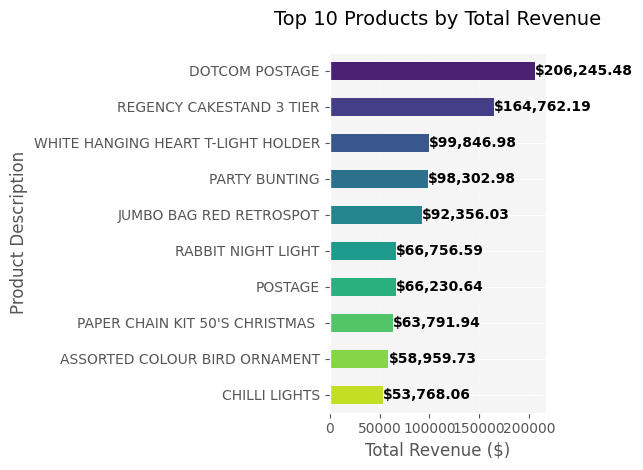

In [ ]:
# Get the top ten products by total spend
top_products= df_temp.groupby(['Description'])['total_spend'].sum().sort_values(ascending=False).head(10)

# create  horizontal bar plot
ax= top_products.plot(kind= 'barh', color=sns.color_palette('viridis', len(top_products)))

# Add value on the bars
for i, v in enumerate(top_products):
    ax.text(v + 0.1, i, f'${v:,.2f}', color= 'black', va= 'center', fontweight= 'bold')

# Customize the plot
plt.title('Top 10 Products by Total Revenue', fontsize=14, pad=20)
plt.xlabel('Total Revenue ($)', fontsize=12)
plt.ylabel('Product Description', fontsize=12)
plt.gca().invert_yaxis()  # Highest value at top
plt.grid(axis='x', linestyle='--', alpha=0.3)

# Keep the border/box around the plot
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)


plt.tight_layout()
plt.show()

In [ ]:
# print(str(df_temp.iloc[541904]['InvoiceDate']).split(" ")[0])
# print(pd.to_datetime(str(df_temp.iloc[541904]['InvoiceDate']).split(" ")[0], format="%Y-%m-%d"))

# print(str(df_temp.iloc[541904]['InvoiceDate']).split(" ")[1])
# print(pd.to_datetime(str(df_temp.iloc[541904]['InvoiceDate']).split(" ")[1], format="%H:%M:%S"))

# Better alternatives
# To get just the date part for all rows
# df_temp['InvoiceDate'].dt.date

# To get just the time part for all rows
# df_temp['InvoiceDate'].dt.time

# Or just the hour
# df_temp['InvoiceDate'].dt.hour


In [86]:
df_temp['hour'] = pd.to_datetime(df_temp['InvoiceDate']).dt.hour
df_temp.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend,hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,8


In [87]:
df_temp.groupby('Country')["InvoiceNo"].count().sort_values(ascending=False).head(20)

Country
United Kingdom     495478
Germany              9495
France               8557
EIRE                 8196
Spain                2533
Netherlands          2371
Belgium              2069
Switzerland          2002
Portugal             1519
Australia            1259
Norway               1086
Italy                 803
Channel Islands       758
Finland               695
Cyprus                622
Sweden                462
Unspecified           446
Austria               401
Denmark               389
Japan                 358
Name: InvoiceNo, dtype: int64

<Axes: ylabel='Country'>

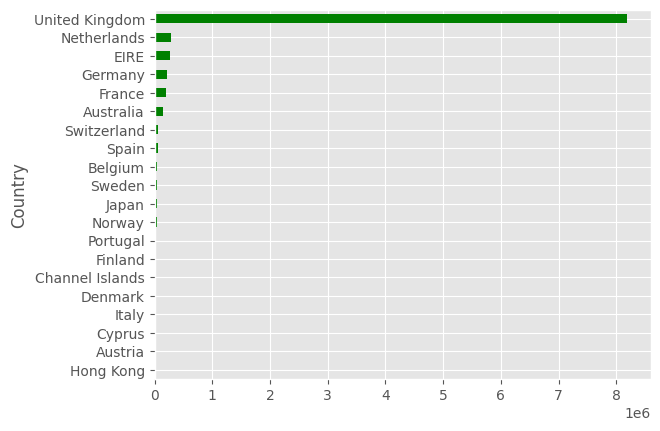

In [96]:
df_temp.groupby('Country')["total_spend"].sum().sort_values(ascending=False).head(20).sort_values(ascending= True).plot(kind='barh', color= 'g')

<Axes: >

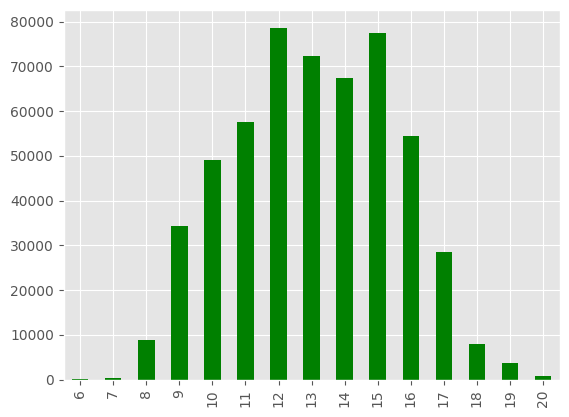

In [97]:
df_temp['hour'].value_counts().sort_index().plot(kind='bar', color= 'g')

Text(0.5, 1.0, 'Total Spend by Hour in United Kingdom')

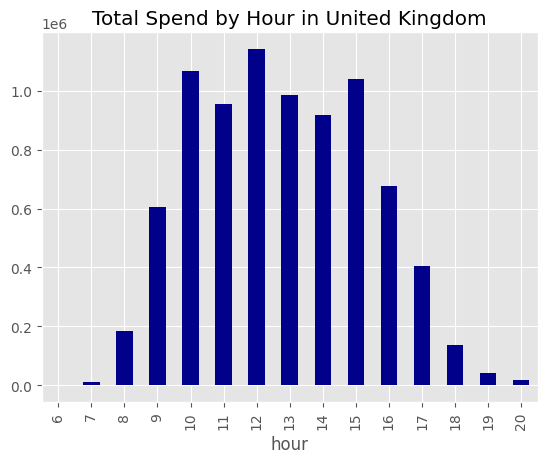

In [98]:
country = "United Kingdom"
df_temp.loc[df_temp['Country'] == f"{country}"].groupby('hour')['total_spend'].sum().plot(kind='bar', color='darkblue')
plt.title(f"Total Spend by Hour in {country}")

In [99]:
df_temp.describe()

,Quantity,UnitPrice,CustomerID,total_spend,hour
count,541909.000000,541909.000000,541909.000000,541909.000000,541909.000000
mean,9.552250,4.611114,11476.974671,17.987795,13.078729
std,218.081158,96.759853,6777.908326,378.810824,2.443270
min,-80995.000000,-11062.060000,0.000000,-168469.600000,6.000000
25%,1.000000,1.250000,12352.000000,3.400000,11.000000
50%,3.000000,2.080000,14382.000000,9.750000,13.000000
75%,10.000000,4.130000,16255.000000,17.400000,15.000000
max,80995.000000,38970.000000,18287.000000,168469.600000,20.000000


In [100]:
df_temp.loc[df_temp['Quantity'] >= 60_000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend,hour
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,77183.6,10
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom,168469.6,9


In [101]:
df_temp.loc[df_temp['UnitPrice'] >= 30_000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend,hour
222681,C556445,M,Manual,-1,2011-06-10 15:31:00,38970.0,15098,United Kingdom,-38970.0,15


In [ ]:
df_temp[df_temp['StockCode'] == 'm']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend,hour


In [103]:
df_temp['StockCode'] = df_temp['StockCode'].str.upper()

In [104]:
df_temp[df_temp['StockCode'] == 'M']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend,hour
2239,536569,M,Manual,1,2010-12-01 15:35:00,1.25,16274,United Kingdom,1.25,15
2250,536569,M,Manual,1,2010-12-01 15:35:00,18.95,16274,United Kingdom,18.95,15
5684,536865,M,Manual,1,2010-12-03 11:28:00,2.55,0,United Kingdom,2.55,11
6798,536981,M,Manual,2,2010-12-03 14:26:00,0.85,14723,United Kingdom,1.70,14
7976,537077,M,Manual,12,2010-12-05 11:59:00,0.42,17062,United Kingdom,5.04,11
...,...,...,...,...,...,...,...,...,...,...
531432,580956,M,Manual,4,2011-12-06 14:23:00,1.25,17841,United Kingdom,5.00,14
533082,C581009,M,Manual,-1,2011-12-07 09:15:00,125.00,16971,United Kingdom,-125.00,9
534308,C581145,M,Manual,-1,2011-12-07 13:48:00,9.95,17490,United Kingdom,-9.95,13
538321,581405,M,Manual,3,2011-12-08 13:50:00,0.42,13521,United Kingdom,1.26,13


In [105]:
df_temp[df_temp['Description'] == 'Manual']['total_spend'].describe()

count      572.000000
mean      -120.055315
std       1833.245373
min     -38970.000000
25%        -65.947500
50%          1.000000
75%          9.315000
max       4287.630000
Name: total_spend, dtype: float64

In [106]:
df_temp['Description'].value_counts().tail(20)

Found by jackie                       1
CREAM SWEETHEART TRAYS                1
BLUE/NAT SHELL NECKLACE W PENDANT     1
PINK ALLIUM  ARTIFICIAL FLOWER        1
BAROQUE BUTTERFLY EARRINGS MONTANA    1
WHITE FRANGIPANI HAIR CLIP            1
INCENSE BAZAAR PEACH                  1
GLASS BEAD HOOP NECKLACE BLACK        1
TINY CRYSTAL BRACELET RED             1
BLUE CRYSTAL BOOT PHONE CHARM         1
damages                               1
VINTAGE BLUE TINSEL REEL              1
WEEKEND BAG VINTAGE ROSE PAISLEY      1
WRAP  PINK FLOCK                      1
PINK LARGE JEWELED PHOTOFRAME         1
FLAMINGO LIGHTS                       1
TRAVEL CARD WALLET DOTCOMGIFTSHOP     1
WHITE WITH METAL BAG CHARM            1
GREEN WITH METAL BAG CHARM            1
BLOSSOM IMAGES SCRAP BOOK SET         1
Name: Description, dtype: int64

In [107]:
df_temp.loc[df_temp['Description'] == 'historic computer difference?....se']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend,hour


In [108]:
df_temp.loc[df_temp['StockCode'] == '84944']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend,hour
1369,536538,84944,SET OF 6 KASHMIR FOLKART BAUBLES,2,2010-12-01 13:54:00,4.25,14594,United Kingdom,8.50,13
6402,536943,84944,SET OF 6 KASHMIR FOLKART BAUBLES,2,2010-12-03 12:11:00,4.25,17884,United Kingdom,8.50,12
10102,537225,84944,SET OF 6 KASHMIR FOLKART BAUBLES,4,2010-12-05 16:41:00,4.25,12748,United Kingdom,17.00,16
13169,537421,84944,SET OF 6 KASHMIR FOLKART BAUBLES,3,2010-12-06 15:25:00,4.25,17218,United Kingdom,12.75,15
16265,537646,84944,SET OF 6 KASHMIR FOLKART BAUBLES,1,2010-12-07 15:39:00,4.25,17591,United Kingdom,4.25,15
...,...,...,...,...,...,...,...,...,...,...
428607,573486,84944,SET OF 6 KASHMIR FOLKART BAUBLES,6,2011-10-31 11:40:00,1.65,13186,United Kingdom,9.90,11
428648,573492,84944,SET OF 6 KASHMIR FOLKART BAUBLES,1,2011-10-31 11:57:00,1.65,13544,United Kingdom,1.65,11
432975,573901,84944,SET OF 6 KASHMIR FOLKART BAUBLES,4,2011-11-01 14:49:00,1.65,14191,United Kingdom,6.60,14
433089,573904,84944,SET OF 6 KASHMIR FOLKART BAUBLES,1,2011-11-01 14:54:00,1.65,14505,United Kingdom,1.65,14


In [109]:
df_temp.loc[df_temp['Description'] == 'Missing']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend,hour


In [110]:
df_temp.loc[df_temp['StockCode'] == '22458'].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend,hour
2729,536592,22458,CAST IRON HOOK GARDEN FORK,1,2010-12-01 17:06:00,5.06,0,United Kingdom,5.06,17
7558,537045,22458,CAST IRON HOOK GARDEN FORK,1,2010-12-05 10:54:00,2.55,15038,United Kingdom,2.55,10
10524,537237,22458,CAST IRON HOOK GARDEN FORK,1,2010-12-06 09:58:00,5.06,0,United Kingdom,5.06,9
14665,537608,22458,CAST IRON HOOK GARDEN FORK,2,2010-12-07 13:20:00,2.55,15024,United Kingdom,5.10,13
19921,537955,22458,CAST IRON HOOK GARDEN FORK,1,2010-12-09 11:28:00,2.55,16782,United Kingdom,2.55,11


In [111]:
df_temp[df_temp['StockCode'].str.contains('90126')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend,hour
27255,538524,90126A,PINK BERTIE MOBILE PHONE CHARM,1,2010-12-13 09:35:00,3.36,0,United Kingdom,3.36,9
265413,560225,90126C,AMBER BERTIE MOBILE PHONE CHARM,2,2011-07-15 16:27:00,3.29,0,United Kingdom,6.58,16


In [112]:
df_temp[df_temp['StockCode'].apply(lambda x: len(x) < 5)]['StockCode'].value_counts()

POST    1256
DOT      710
M        572
C2       144
D         77
S         63
CRUK      16
PADS       4
B          3
Name: StockCode, dtype: int64

In [116]:
# How many times each duplicate appears
dupe_counts = df_temp[df_temp.duplicated(keep=False)].groupby(list(df_temp.columns)).size().reset_index(name='count')
dupe_counts = dupe_counts[dupe_counts['count'] > 1]  # Only show actual duplicates
dupe_counts = dupe_counts.sort_values('count', ascending=False)
dupe_counts

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend,hour,count
1614,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923,United Kingdom,2.95,11,20
1613,555524,22697,GREEN REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923,United Kingdom,2.95,11,12
3203,572861,22775,PURPLE DRAWERKNOB ACRYLIC EDWARDIAN,12,2011-10-26 12:46:00,1.25,14102,United Kingdom,15.00,12,8
529,541266,21755,LOVE BUILDING BLOCK WORD,1,2011-01-16 16:25:00,5.95,15673,United Kingdom,5.95,16,6
3147,572344,M,Manual,48,2011-10-24 10:43:00,1.50,14607,United Kingdom,72.00,10,6
...,...,...,...,...,...,...,...,...,...,...,...
1683,556484,22139,RETROSPOT TEA SET CERAMIC 11 PC,1,2011-06-12 13:17:00,4.95,16938,United Kingdom,4.95,13,2
1682,556481,23182,TOILET SIGN OCCUPIED OR VACANT,3,2011-06-12 13:00:00,0.83,16115,United Kingdom,2.49,13,2
1681,556473,22727,ALARM CLOCK BAKELIKE RED,1,2011-06-12 12:00:00,3.75,17265,United Kingdom,3.75,12,2
1680,556473,21069,VINTAGE BILLBOARD TEA MUG,1,2011-06-12 12:00:00,1.25,17265,United Kingdom,1.25,12,2


In [118]:
df_temp[df_temp['StockCode'] == "M"]
# df_temp[df_temp['StockCode'].str.contains('POST')]
# df_temp[df_temp['InvoiceNo'].str.startswith('C')]
# df_temp[df_temp['StockCode'].str.contains('DOT')]['StockCode'].value_counts()
# df_temp[df_temp['StockCode'].str.contains('C2')]['Country'].value_counts()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend,hour
2239,536569,M,Manual,1,2010-12-01 15:35:00,1.25,16274,United Kingdom,1.25,15
2250,536569,M,Manual,1,2010-12-01 15:35:00,18.95,16274,United Kingdom,18.95,15
5684,536865,M,Manual,1,2010-12-03 11:28:00,2.55,0,United Kingdom,2.55,11
6798,536981,M,Manual,2,2010-12-03 14:26:00,0.85,14723,United Kingdom,1.70,14
7976,537077,M,Manual,12,2010-12-05 11:59:00,0.42,17062,United Kingdom,5.04,11
...,...,...,...,...,...,...,...,...,...,...
531432,580956,M,Manual,4,2011-12-06 14:23:00,1.25,17841,United Kingdom,5.00,14
533082,C581009,M,Manual,-1,2011-12-07 09:15:00,125.00,16971,United Kingdom,-125.00,9
534308,C581145,M,Manual,-1,2011-12-07 13:48:00,9.95,17490,United Kingdom,-9.95,13
538321,581405,M,Manual,3,2011-12-08 13:50:00,0.42,13521,United Kingdom,1.26,13


In [119]:
df_temp.groupby('StockCode')['Description'].value_counts().head(20)

StockCode  Description                 
10002      INFLATABLE POLITICAL GLOBE       73
10080      GROOVY CACTUS INFLATABLE         24
10120      DOGGY RUBBER                     30
10123C     HEARTS WRAPPING TAPE              4
10123G     No Description                    1
10124A     SPOTS ON RED BOOKCOVER TAPE       5
10124G     ARMY CAMO BOOKCOVER TAPE          4
10125      MINI FUNKY DESIGN TAPES          94
10133      COLOURING PENCILS BROWN TUBE    200
10134      No Description                    1
10135      COLOURING PENCILS BROWN TUBE    180
11001      ASSTD DESIGN RACING CAR PEN     120
15030      FAN BLACK FRAME                  14
15034      PAPER POCKET TRAVELING FAN      142
15036      ASSORTED COLOURS SILK FAN       524
15039      SANDALWOOD FAN                  149
15044A     PINK PAPER PARASOL              104
15044B     BLUE PAPER PARASOL               62
15044C     PURPLE PAPER PARASOL             91
15044D     RED PAPER PARASOL                87
Name: Description, d

In [120]:
df_temp.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'total_spend', 'hour'],
      dtype='object')

In [121]:
# Standardize product descriptions by using the most frequent description for each StockCode
# This handles cases where the same product has slightly different descriptions
# (e.g., extra spaces, case differences, or typos)

most_freq = df_temp.groupby('StockCode')['Description'].agg(lambda x: x.value_counts().idxmax()).reset_index()


In [124]:
df = pd.merge(df_temp, most_freq, on='StockCode', how='left', suffixes=('_original', '_standardized')) # Custom suffixes
df.head()

,InvoiceNo,StockCode,Description_original,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend,hour,Description_standardized
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,8,WHITE HANGING HEART T-LIGHT HOLDER
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,8,WHITE METAL LANTERN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,8,CREAM CUPID HEARTS COAT HANGER
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,8,KNITTED UNION FLAG HOT WATER BOTTLE
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,8,RED WOOLLY HOTTIE WHITE HEART.


In [126]:
df = df.drop(columns=['Description_original'])
df = df.rename(columns={'Description_standardized': 'Description'})
df = df.reindex(columns=['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country', 'total_spend', 'hour'])

In [129]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend,hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,8


In [130]:
df_temp.loc[df_temp['Description'] == 'damaged'].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend,hour


In [131]:
df_temp.loc[df_temp['StockCode'].str.contains("10123")]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend,hour
5451,536863,10123C,HEARTS WRAPPING TAPE,1,2010-12-03 11:19:00,0.65,17967,United Kingdom,0.65,11
109611,545655,10123C,HEARTS WRAPPING TAPE,3,2011-03-04 13:58:00,0.65,14670,United Kingdom,1.95,13
140929,548491,10123C,HEARTS WRAPPING TAPE,1,2011-03-31 13:14:00,0.65,14064,United Kingdom,0.65,13
150159,549349,10123G,No Description,-38,2011-04-08 11:13:00,0.00,0,United Kingdom,-0.00,11
265293,560213,10123C,HEARTS WRAPPING TAPE,-18,2011-07-15 15:05:00,0.00,0,United Kingdom,-0.00,15


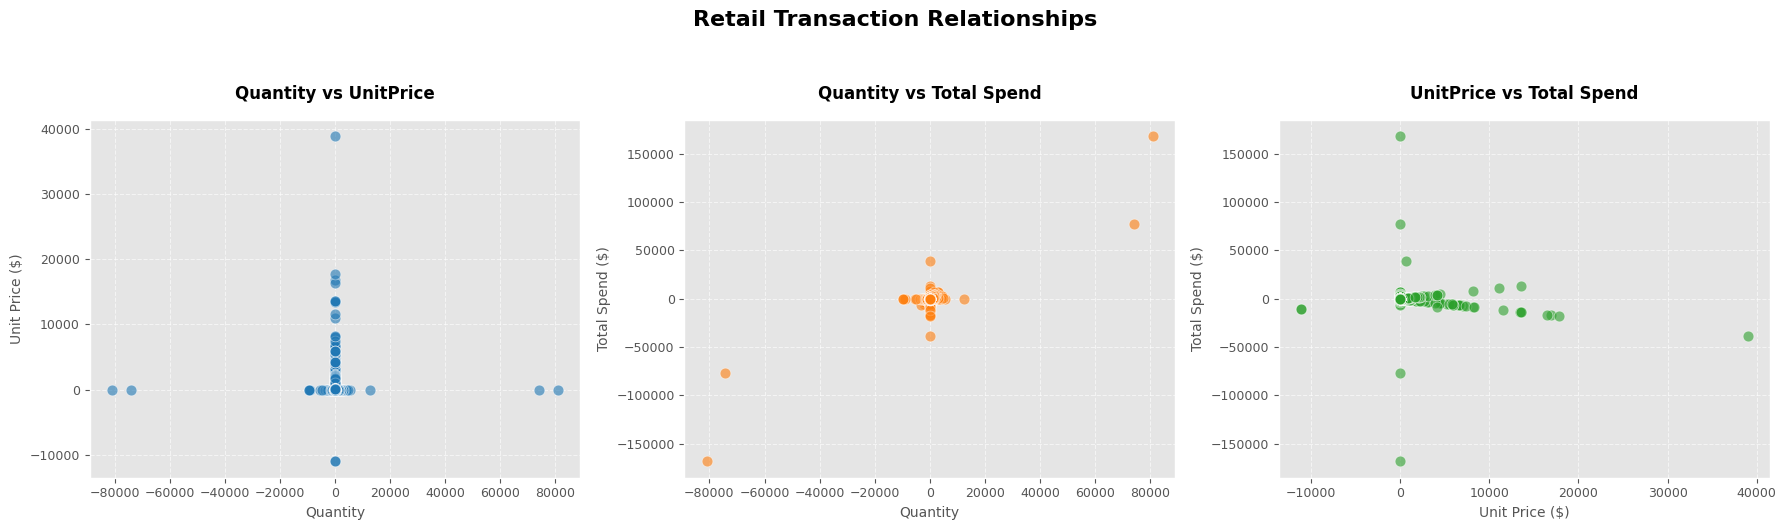

In [134]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Adjust space between subplots

# Common plot settings
plot_kwargs = {
    'alpha': 0.6,           # Slightly transparent points
    'edgecolor': 'w',       # White border around points
    's': 60                 # Point size
}

# 1. Quantity vs UnitPrice
sc1 = ax[0].scatter(
    x=df_temp['Quantity'], 
    y=df_temp['UnitPrice'],
    c='#1f77b4',  # Nice blue color
    **plot_kwargs
)
ax[0].set_title('Quantity vs UnitPrice', pad=15, fontsize=12, fontweight='bold')
ax[0].set_xlabel('Quantity', fontsize=10)
ax[0].set_ylabel('Unit Price ($)', fontsize=10)
ax[0].tick_params(labelsize=9)
ax[0].grid(True, linestyle='--', alpha=0.6)

# 2. Quantity vs Total Spend
sc2 = ax[1].scatter(
    x=df_temp['Quantity'], 
    y=df_temp['total_spend'],
    c='#ff7f0e',  # Orange color
    **plot_kwargs
)
ax[1].set_title('Quantity vs Total Spend', pad=15, fontsize=12, fontweight='bold')
ax[1].set_xlabel('Quantity', fontsize=10)
ax[1].set_ylabel('Total Spend ($)', fontsize=10)
ax[1].tick_params(labelsize=9)
ax[1].grid(True, linestyle='--', alpha=0.6)

# 3. UnitPrice vs Total Spend
sc3 = ax[2].scatter(
    x=df_temp['UnitPrice'], 
    y=df_temp['total_spend'],
    c='#2ca02c',  # Green color
    **plot_kwargs
)
ax[2].set_title('UnitPrice vs Total Spend', pad=15, fontsize=12, fontweight='bold')
ax[2].set_xlabel('Unit Price ($)', fontsize=10)
ax[2].set_ylabel('Total Spend ($)', fontsize=10)
ax[2].tick_params(labelsize=9)
ax[2].grid(True, linestyle='--', alpha=0.6)


# Add a main title
plt.suptitle('Retail Transaction Relationships', 
             fontsize=16, 
             fontweight='bold', 
             y=1.05)

plt.tight_layout()
plt.show()

---

In [ ]:
# Final Data Cleaning and Export
# =============================

# Load fresh data (in case we modified it during EDA)
# df= pd.read_csv(r"E:\Smartcart_Retail_Analytics\data\uncleaned_data.csv", encoding= 'latin1')
df = pd.read_csv("./data/uncleaned_data.csv", encoding='cp1252')

# Clean the data
# Handling missing values
# df['Description'] = df['Description'].fillna('No Description')
df['CustomerID'] = df['CustomerID'].fillna(0)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['total_spend'] = df['Quantity'] * df['UnitPrice']

# convert datatypes
df['InvoiceNo'] = df['InvoiceNo'].astype(str)
df['StockCode'] = df['StockCode'].astype(str)
df['Description'] = df['Description'].astype(str)
df['CustomerID'] = df['CustomerID'].astype(float).astype(int)
df['Country'] = df['Country'].astype(str)
df['total_spend'] = df['total_spend'].astype(float)

# Standardize product description
df['StockCode'] = df['StockCode'].str.upper()
most_freq = df.groupby('StockCode')['Description'].agg(lambda x: x.value_counts().idxmax()).reset_index()
columns_index = df.columns
df = df.drop(columns=['Description'])
df = pd.merge(df, most_freq, on='StockCode', how='left')
df = df.reindex(columns= columns_index)

# Write the cleaned data to a new csv file
# df.to_parquet("./data/cleaned_data.parquet")
df.to_csv("./data/cleaned_data.csv")

---